In [5]:
import os
import sqlalchemy as db
import geopandas as gpd
import pandas as pd
import osmnx
from shapely.geometry import box, LineString, Point
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json

In [6]:
POSTGRES_HOST="xxxx"
POSTGRES_PORT="xxxx"
POSTGRES_DB="xxxx"
POSTGRES_SCHEMA="xxxx"
POSTGRES_USER="xxxx"
POSTGRES_PASSWORD="xxxx"

In [7]:
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=POSTGRES_USER,
                                   pw=POSTGRES_PASSWORD,
                                   host=POSTGRES_HOST,
                                   db=POSTGRES_DB,
                                   port=POSTGRES_PORT))

In [8]:
connection = engine.connect()

# Study area of Tunisia

	Course	Distance	Coordinate
1.	91.32°	222.49 nm	N 36.311° - E 13.323°
2.	301.04°	1.31 nm	N 36.323° - E 13.300°
3.	359.25°	127.22 nm	N 38.441° - E 13.265°
4.	273.77°	205.68 nm	N 38.585° - E 8.891°
5.	183.41°	124.88 nm	N 36.508° - E 8.736°

In [9]:
min_lon =8.736
min_lat = 36.311
max_lon= 13.323
max_lat=  38.585
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_wkt = bbox.wkt
bbox_wkt

'POLYGON ((13.323 36.311, 13.323 38.585, 8.736 38.585, 8.736 36.311, 13.323 36.311))'

In [10]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((13.323 36.311, 13.323 38.585, 8.736 38.585, 8.736 36.311, 13.323 36.311))', 4326)) AND (tags -> 'seamark:type'='separation_boundary' OR tags -> 'seamark:type'='separation_line' OR tags -> 'seamark:type'='separation_zone' OR tags -> 'seamark:type'='separation_lane')"
gdf_ways = gpd.read_postgis(query, engine)
#gdf_ways = gpd.read_postgis(query, engine)
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf_ways
gdf_ways.explore()

In [7]:
    filename = 'Data/route_2.geojson'
    filename = '/ROUTE/min_time_route.json'
    with open(filename) as file:
        rp_dict = json.load(file)

    point_list = rp_dict['features']
    count = len(point_list)
    lats_per_step = np.full(count, -99, dtype=float)
    lons_per_step = np.full(count, -99, dtype=float)

    color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                  'lightred',
                  'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple',
                  'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black',
                  'lightgray']

    for ipoint in range(0, count):
        coord_pair = point_list[ipoint]['geometry']['coordinates']
        lats_per_step[ipoint] = coord_pair[1]
        lons_per_step[ipoint] = coord_pair[0]

    # Create LineString segments from X and Y columns
    segments = []
    for i in range(len(lons_per_step) - 1):
        segment = LineString([(lons_per_step[i], lats_per_step[i]),
                              (lons_per_step[i + 1], lats_per_step[i + 1])])
        segments.append(segment)

    # Add LineString segments to a new GeoDataFrame
    segments_gdf = gpd.GeoDataFrame(geometry=segments, crs="EPSG:4326")

    # Print the segments GeoDataFrame
    print(segments_gdf)


                                            geometry
0  LINESTRING (12.41500 37.66700, 11.71534 37.52821)
1  LINESTRING (11.71534 37.52821, 10.91776 37.40824)
2  LINESTRING (10.91776 37.40824, 10.07823 37.42354)
3   LINESTRING (10.07823 37.42354, 9.43700 37.55550)


In [8]:
seamark_gdf = gdf_ways 

seg geometry    LINESTRING (12.415 37.667, 11.715339790563805 ...
Name: 0, dtype: object
interesct point id                                                      308520797
version                                                         1
user_id                                                    554973
tstamp                                        2014-10-19 05:28:12
changeset_id                                             26186018
tags                          {'seamark:type': 'separation_lane'}
nodes                                    [3137900430, 3137900435]
linestring      0102000020E6100000020000001B193FE834AE2640030D...
bbox            0103000020E61000000100000005000000BD676ECF3D61...
geometry             POINT (11.201409618064403 37.45090820479969)
Name: 0, dtype: object
interesct point id                                                      308520799
version                                                         1
user_id                                                    55497

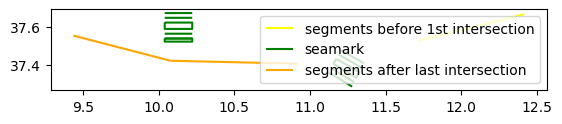

          x          y
0  11.71534  37.528213
           x          y
2  10.917762  37.408243


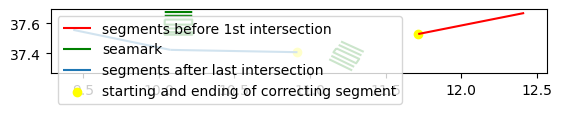

In [9]:
 # Perform spatial overlay to find intersections
intersection = gpd.overlay(segments_gdf, seamark_gdf, how='intersection',
                               keep_geom_type=False)


first_node = 0
indx_intersect = []
for index, seg in segments_gdf.iterrows():
    print('seg', seg)
    for j, inter_point in intersection.iterrows():
        print('interesct point', inter_point)
        buffered_point = inter_point.geometry.buffer(0.000001)
        val = seg.geometry.intersects(buffered_point)
        if (val):
            print('____________________________________________')
            indx_intersect.append(index)

print(indx_intersect)
segments_before_df = segments_gdf[0:indx_intersect[0]]

last_index = indx_intersect[len(indx_intersect) - 1]
last_index = last_index + 1
segments_after = segments_gdf[last_index:]

fig, ax = plt.subplots()
segments_before_df.plot(ax=ax, color='yellow',
                            label='segments before 1st intersection')
seamark_gdf.plot(ax=ax, color='green', label='seamark')
segments_after.plot(ax=ax, color = 'orange', label='segments after last intersection')
ax.legend()
plt.show()

first_node_line = segments_before_df.tail(1).geometry.get_coordinates()
point_start = first_node_line.tail(1)
print(point_start)
point_A = Point(point_start.x, point_start.y)

first_node_line = segments_after.head(1).geometry.get_coordinates()
point_end = first_node_line.head(1)
print(point_end)
point_B = Point(point_end.x, point_end.y)

points = [point_A, point_B]
p = gpd.GeoSeries(points)

fig, ax = plt.subplots()
segments_before_df.plot(ax=ax, color='red',
                            label='segments before 1st intersection')
seamark_gdf.plot(ax=ax, color='green', label='seamark')
segments_after.plot(ax=ax, label='segments after last intersection')
p.plot(ax=ax, color='yellow', label='starting and ending of correcting segment' )
ax.legend()
plt.show()

In [10]:
print(point_A)

POINT (11.715339790563805 37.52821254396468)


In [11]:
print(point_B)

POINT (10.917762243471175 37.4082425392635)


## Find the traffic separation lanes

In [12]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((13.323 36.311, 13.323 38.585, 8.736 38.585, 8.736 36.311, 13.323 36.311))', 4326)) AND ( tags -> 'seamark:type'='separation_lane')"
gdf_ways = gpd.read_postgis(query, engine)
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf_ways

,id,version,user_id,tstamp,changeset_id,tags,nodes,linestring,bbox,geom
0,308520793,1,554973,2014-10-19 05:28:12,26186018,{'seamark:type': 'separation_lane'},"[3137900431, 3137899926]",0102000020E610000002000000453A4DB0494826401A13...,0103000020E61000000100000005000000453A4DB04948...,"LINESTRING (11.14119 37.38447, 11.29208 37.31145)"
1,308520797,1,554973,2014-10-19 05:28:12,26186018,{'seamark:type': 'separation_lane'},"[3137900430, 3137900435]",0102000020E6100000020000001B193FE834AE2640030D...,0103000020E61000000100000005000000BD676ECF3D61...,"LINESTRING (11.34025 37.38724, 11.18992 37.45617)"
2,898527699,1,554973,2021-01-22 16:13:50,97985515,{'seamark:type': 'separation_lane'},"[8349670162, 8349670163]",0102000020E61000000200000072B8A008F31424400FB4...,0103000020E6100000010000000500000072B8A008F314...,"LINESTRING (10.04092 37.56513, 10.22284 37.56515)"
3,898527700,1,554973,2021-01-22 16:13:50,97985515,{'seamark:type': 'separation_lane'},"[8349670160, 8349670161]",0102000020E6100000020000006A238DC00E72244022E4...,0103000020E6100000010000000500000031BE1E02FD14...,"LINESTRING (10.22277 37.64852, 10.04099 37.64844)"


In [13]:
gdf_ways.explore()


In [14]:
dist_list = []
for line in gdf_ways.geom:
    seamark_lane_segment = line
    x,y = seamark_lane_segment.xy
    seamark_start_point = Point(x[0], y[0])
    dist = point_A.distance(seamark_start_point)
    dist_list.append(dist)
    print(dist)

mind_dist_index = dist_list.index(min(dist_list))
print(mind_dist_index)

0.5918714820647628
0.4007077308844688
1.6748300717884463
1.4974118305328072
1


In [15]:
seperation_lane = gdf_ways.loc[mind_dist_index]
#seperation_lane_geom['geom'] =seperation_lane['geom']
print(type(seperation_lane))

<class 'pandas.core.series.Series'>


In [16]:
seperation_lane

id                                                      308520797
version                                                         1
user_id                                                    554973
tstamp                                        2014-10-19 05:28:12
changeset_id                                             26186018
tags                          {'seamark:type': 'separation_lane'}
nodes                                    [3137900430, 3137900435]
linestring      0102000020E6100000020000001B193FE834AE2640030D...
bbox            0103000020E61000000100000005000000BD676ECF3D61...
geom            LINESTRING (11.3402474 37.3872431, 11.1899247 ...
Name: 1, dtype: object

In [17]:
from shapely.ops import linemerge

In [18]:
seperation_lane_geom = seperation_lane.geom

In [19]:
print(seperation_lane_geom)
print(type(seperation_lane_geom))

LINESTRING (11.3402474 37.3872431, 11.1899247 37.4561747)
<class 'shapely.geometry.linestring.LineString'>


In [20]:
print(type(segments_before_df))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [21]:
segments_after

,geometry
2,"LINESTRING (10.91776 37.40824, 10.07823 37.42354)"
3,"LINESTRING (10.07823 37.42354, 9.43700 37.55550)"


## =============================================================================

In [22]:
segments_before_df

,geometry
0,"LINESTRING (12.41500 37.66700, 11.71534 37.52821)"


Shapely LineString: LINESTRING (12.415 37.667, 11.715339790563805 37.52821254396468)


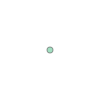

In [23]:
# Create ´connecting lines
last_line_start_seg = segments_before_df.tail(1)

geom =last_line_start_seg['geometry']
# Access one of the LineString geometries from the GeoSeries (for example, the first one)
line_gdf = last_line_start_seg.iloc[0]

# Convert the GeoDataFrame to a Shapely LineString
line_shapely = LineString(line_gdf.geometry.coords)

print("Shapely LineString:", line_shapely)
x, y = line_shapely.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
last_point_rs = Point([df['x'].tail(1),df['y'].tail(1)])
last_point_rs

In [24]:
seperation_lane = gdf_ways.loc[mind_dist_index]
print(seperation_lane.geom)
print(type(seperation_lane.geom))

LINESTRING (11.3402474 37.3872431, 11.1899247 37.4561747)
<class 'shapely.geometry.linestring.LineString'>


In [25]:
x, y = seperation_lane.geom.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)

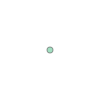

In [26]:
firts_point_sl = Point([df['x'].head(1),df['y'].head(1)])
firts_point_sl

In [27]:
segments_1 = LineString([last_point_rs,firts_point_sl ])
print(segments_1)

LINESTRING (11.715339790563805 37.52821254396468, 11.3402474 37.3872431)


#==============================

Shapely LineString: LINESTRING (10.917762243471175 37.4082425392635, 10.078227581932445 37.423535743498356)


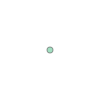

In [28]:
# Create ´connecting lines
first_line_end_seg = segments_after.head(1)

geom =first_line_end_seg['geometry']
# Access one of the LineString geometries from the GeoSeries (for example, the first one)
line_gdf = first_line_end_seg.iloc[0]

# Convert the GeoDataFrame to a Shapely LineString
line_shapely = LineString(line_gdf.geometry.coords)

print("Shapely LineString:", line_shapely)
x, y = line_shapely.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
first_point_rs = Point([df['x'].head(1),df['y'].head(1)])
first_point_rs

LINESTRING (11.3402474 37.3872431, 11.1899247 37.4561747)
<class 'shapely.geometry.linestring.LineString'>


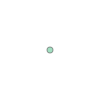

In [29]:
seperation_lane = gdf_ways.loc[mind_dist_index]
print(seperation_lane.geom)
print(type(seperation_lane.geom))
x, y = seperation_lane.geom.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
last_point_sl = Point([df['x'].tail(1),df['y'].tail(1)])
last_point_sl

In [30]:
segments_2 = LineString([last_point_sl,first_point_rs ])
print(segments_2)

LINESTRING (11.1899247 37.4561747, 10.917762243471175 37.4082425392635)


## =================================================

In [31]:
# Create a new GeoDataFrame with the new LineString
first_line_Seg =  gpd.GeoDataFrame(geometry=[segments_1], crs=segments_before_df.crs)
seperation_lane = gpd.GeoDataFrame(geometry=[seperation_lane_geom], crs=segments_before_df.crs)
second_line_Seg =  gpd.GeoDataFrame(geometry=[segments_2], crs=segments_before_df.crs)

# Append the new GeoDataFrame to the existing one
#combined_gdf = segments_before_df.append(new_gdf, ignore_index=True)
combined_first_route_gdf = gpd.GeoDataFrame(pd.concat([segments_before_df, first_line_Seg], ignore_index=True), crs=segments_before_df.crs)
combined_gdf = gpd.GeoDataFrame(pd.concat([combined_first_route_gdf, seperation_lane], ignore_index=True), crs=segments_before_df.crs)
combined_last_route_seg = gpd.GeoDataFrame(pd.concat([combined_gdf, second_line_Seg], ignore_index=True), crs=segments_before_df.crs)
final_route = gpd.GeoDataFrame(pd.concat([combined_last_route_seg, segments_after], ignore_index=True), crs=segments_before_df.crs)
# Now combined_gdf contains the original LineStrings along with the new LineString
#print(combined_gdf)
# Now combined_gdf contains the original LineStrings along with the new LineString
print(final_route)

                                            geometry
0  LINESTRING (12.41500 37.66700, 11.71534 37.52821)
1  LINESTRING (11.71534 37.52821, 11.34025 37.38724)
2  LINESTRING (11.34025 37.38724, 11.18992 37.45617)
3  LINESTRING (11.18992 37.45617, 10.91776 37.40824)
4  LINESTRING (10.91776 37.40824, 10.07823 37.42354)
5   LINESTRING (10.07823 37.42354, 9.43700 37.55550)


In [32]:
final_route.explore()

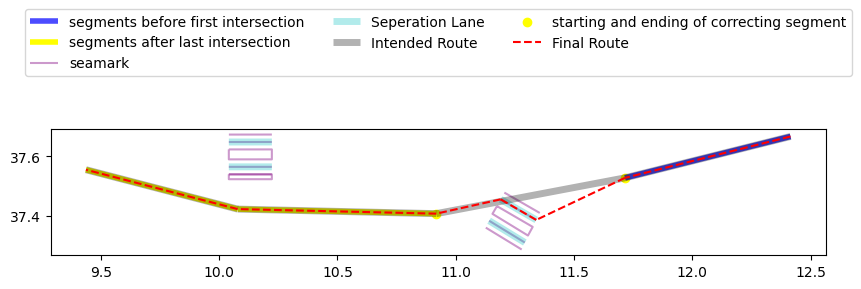

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

segments_before_df.plot(ax=ax, color='blue',alpha=0.7,label='segments before first intersection', linewidth=4)
segments_after.plot(ax=ax, color='yellow',label='segments after last intersection',  linewidth=4)
seamark_gdf.plot(ax=ax, color='purple', alpha=0.4, label='seamark')

gdf_ways.plot(ax=ax,  color='c',alpha=0.3, label='Seperation Lane',  linewidth=5)
segments_gdf.plot(ax=ax,  color='black',alpha=0.3, label='Intended Route',  linewidth=5)

p.plot(ax=ax, color='yellow', label='starting and ending of correcting segment' )
final_route.plot(ax=ax, color = 'red',linestyle='dashed', label='Final Route', linewidth=1.5)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2),
          ncol=3, fancybox=True)
plt.show()
#plt.savefig( 'C:/Users/Maneesha/Documents/52N/TSS/Case1/routes_final.png')